# Content of Chapter 2 - Neural Networks

In [19]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import * 
from tqdm import tqdm
import matplotlib.pyplot as plt

### Functions from Chapter 1

In [20]:
def moveTo(obj, device): 
    """ 
    obj: the python object to move to a device, or to move its
    ➥ contents to a device
    device: the compute device to move objects to 
    """
    if isinstance(obj, list): 
        return [moveTo(x, device) for x in obj] 
    elif isinstance(obj, tuple): 
        return tuple(moveTo(list(obj), device)) 
    elif isinstance(obj, set): 
        return set(moveTo(list(obj), device)) 
    elif isinstance(obj, dict): 
        to_ret = dict() 
        for key, value in obj.items(): 
            to_ret[moveTo(key, device)] = moveTo(value, device) 
        return to_ret 
    elif hasattr(obj, "to"): 
        return obj.to(device) 
    else: 
        return obj

<Axes: >

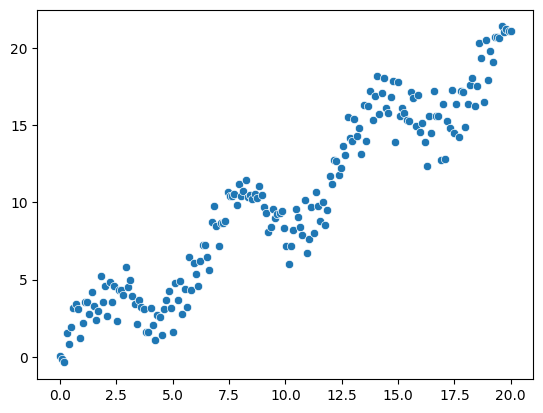

In [21]:
X = np.linspace(0, 20, num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

In [22]:
class Simple1DRegressionDataset(Dataset): 
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__() 
        self.X = X.reshape(-1,1) 
        self.y = y.reshape(-1,1) 
    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self): 
        return self.X.shape[0] 
training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [23]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="cpu"): 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)                    

    model.to(device)                                                             

    for epoch in tqdm(range(epochs), desc="Epoch"):                              
        model = model.train()                                                    
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):  
            inputs = moveTo(inputs, device)                                      
            labels = moveTo(labels, device)                                      

            optimizer.zero_grad()                                                


            y_hat = model(inputs)                                                

            loss = loss_func(y_hat, labels)                                      
            loss.backward()                                                      
            optimizer.step()                                                     
            running_loss += loss.item()    

In [24]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()
device = torch.device('cuda')
train_simple_network(model, loss_func, training_loader, device=device)

Epoch: 100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


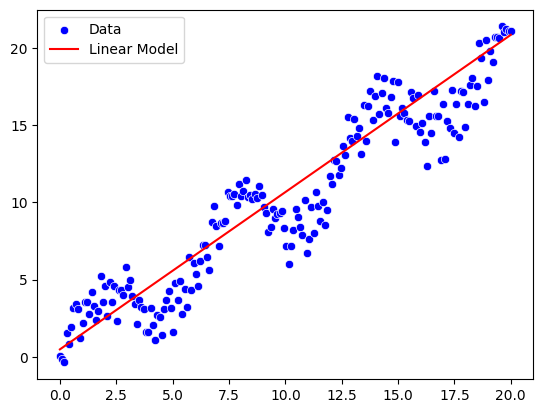

In [25]:
with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')  
    sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear Model')

In [26]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 1),
)

train_simple_network(model, loss_func, training_loader, device=device)

Epoch: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


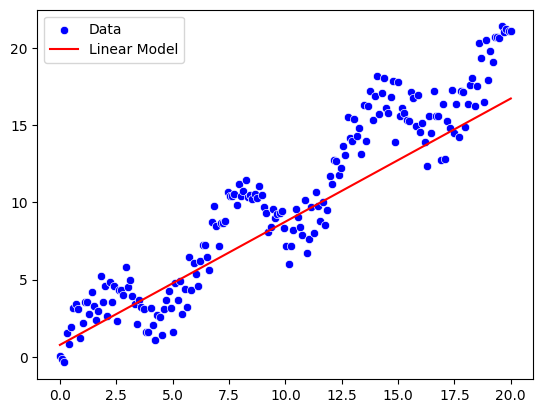

In [27]:
with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')  
    sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear Model')

### Introduce some non linearity to the system

Text(0, 0.5, 'Activation')

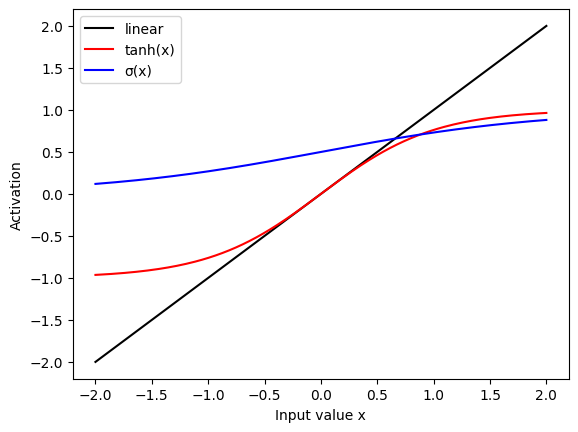

In [28]:
activation_input = np.linspace(-2, 2, num=200) 
tanh_activation = np.tanh(activation_input) 
sigmoid_activation = np.exp(activation_input)/(np.exp(activation_input)+1)
 
sns.lineplot(x=activation_input, y=activation_input, color='black', label="linear") 
sns.lineplot(x=activation_input, y=tanh_activation, color='red', label="tanh(x)") 
ax = sns.lineplot(x=activation_input, y=sigmoid_activation, color='blue', label="σ(x)")

ax.set_xlabel('Input value x')
ax.set_ylabel('Activation')

Epoch: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


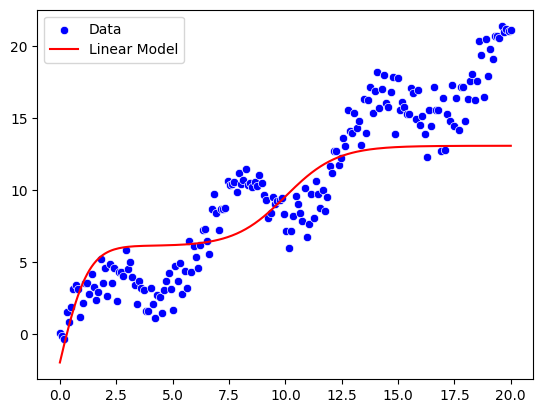

In [29]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 1),
)

train_simple_network(model, loss_func, training_loader, device=device)

with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')  
    sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear Model')

<Axes: >

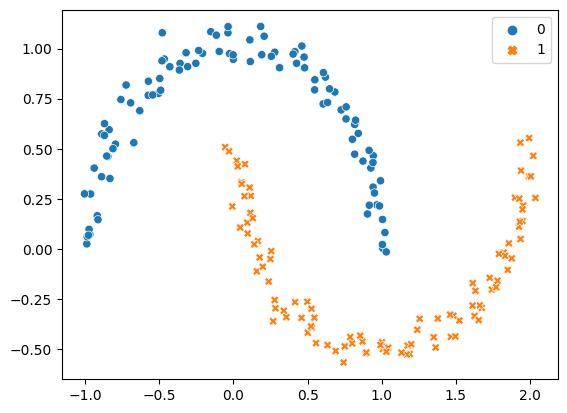

In [31]:
from sklearn.datasets import make_moons 
X, y = make_moons(n_samples=200, noise=0.05) 
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)


In [32]:
classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset)

In [33]:
in_features = 2 
out_features = 2 
model = nn.Linear(in_features, out_features)

In [34]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50)

Epoch: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


In [36]:
def visualize2DSoftmax(X, y, model, title=None): 
    x_min = np.min(X[:,0])-0.5 
    x_max = np.max(X[:,0])+0.5 
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5 
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij') 
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1))) 
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32)) 
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu) 
    ax = plt.gca() 
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax) 
    if title is not None: 
        ax.set_title(title)

visualize2DSoftmax(X, y, model)

NameError: name 'plt' is not defined